In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.stats import norm
from scipy.special import expit

from models.multiGaussian import MultiGaussianAdaptedSkiRental
from models.varianceAware import VarianceAwareSkiRental
from models.expectedCost import ExpectedCostSkiRental
from models.bayesian import BayesianSkiRental
from models.hybrid import HybridVarianceAwareSkiRental, HybridVarianceAwareSkiRentalWithScaling
from models.gaussianNoise import GaussianNoiseSkiRental
from models.bayesianDiscrete import DiscreteBayesianSkiRental


In [2]:
import logging
logging.getLogger("pymc").setLevel(logging.ERROR)
logging.getLogger("pytensor").setLevel(logging.ERROR)


 # Experiment 1 

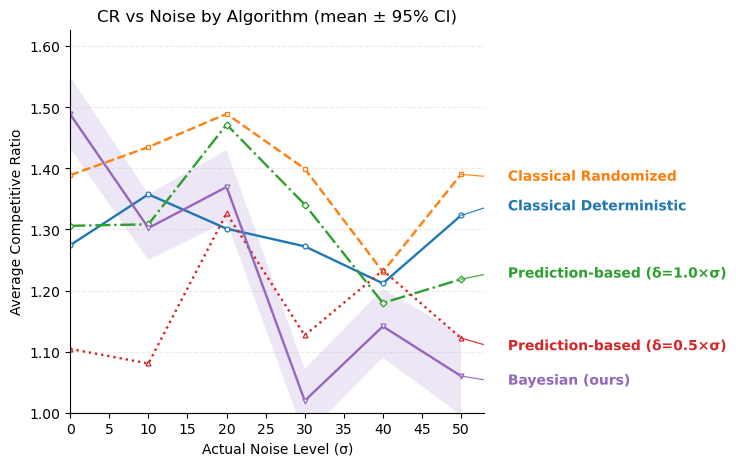

Saved: figs-final/exp1.png


In [ ]:
# -------------------------------------------------
# (6) 플로팅: 선 끝 라벨링(legend 제거, PNG만 저장) — 수평 연장 제거 버전
# -------------------------------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.ticker import MaxNLocator, FuncFormatter

# ===== 데이터 준비: agg 없으면 샘플 생성 =====
if 'agg' not in globals():
    np.random.seed(0)
    algos = [
        "Classical Deterministic",
        "Classical Randomized",
        "Prediction-based (δ=1.0×σ)",
        "Prediction-based (δ=0.5×σ)",
        "Bayesian (ours)"
    ]
    # 일부 알고리즘은 50까지만, 일부는 100까지 만들어 상황 재현
    rows = []
    for algo in algos:
        if algo in ["Classical Deterministic", "Bayesian (ours)"]:
            noise_levels = np.arange(0, 101, 10)   # 0..100
        else:
            noise_levels = np.arange(0, 51, 10)    # 0..50 (이후 없음)

        mean   = 1.05 + 0.45 * np.random.rand(len(noise_levels))
        ci_low = mean - 0.05 - 0.02 * np.random.rand(len(noise_levels))
        ci_high= mean + 0.05 + 0.02 * np.random.rand(len(noise_levels))
        for n, m, lo, hi in zip(noise_levels, mean, ci_low, ci_high):
            rows.append((algo, n, m, lo, hi))
    agg = pd.DataFrame(rows, columns=["algorithm", "noise", "mean", "ci_low", "ci_high"])

# ===== 스타일/순서 =====
order      = agg["algorithm"].unique().tolist()
palette    = list(plt.get_cmap("tab10").colors)
linestyles = ["-", "--", "-.", ":"]
markers    = ["o", "s", "D", "^", "v", "X", "P"]

# ===== 플롯 시작 =====
fig, ax = plt.subplots(figsize=(7.6, 4.8))
end_points = []  # (algo, x_last, y_last, color)

for i, algo in enumerate(order):
    tmp = agg[agg["algorithm"] == algo].copy()
    if tmp.empty:
        continue

    # 안전: numeric + 정렬
    for col in ["noise", "mean", "ci_low", "ci_high"]:
        tmp[col] = pd.to_numeric(tmp[col], errors="coerce")
    tmp = tmp.dropna(subset=["noise", "mean"]).sort_values("noise")

    # >>> 핵심: 패딩/재색인/보간으로 '뒤를 채우지 않음' (수평선 방지)
    x = tmp["noise"].to_numpy()
    y = tmp["mean"].to_numpy()
    lo = tmp["ci_low"].to_numpy()
    hi = tmp["ci_high"].to_numpy()

    color = palette[i % len(palette)]
    ls    = linestyles[i % len(linestyles)]
    mk    = markers[i % len(markers)]

    # 우리 모델만 신뢰구간 음영 (있는 구간까지만)
    if algo == "Bayesian (ours)":
        ax.fill_between(x, lo, hi, alpha=0.16, facecolor=color, edgecolor="none")

    # 모든 모델 라인 + 마커 (있는 구간까지만)
    ax.plot(x, y, linewidth=1.7, linestyle=ls, marker=mk, markersize=3.5,
            markerfacecolor="white", markeredgewidth=0.9, color=color)

    # 라벨용 끝점 = 실제 마지막 데이터 지점
    x_last = float(x[-1])
    y_last = float(y[-1])
    end_points.append((algo, x_last, y_last, color))

# ===== 축/눈금/타이틀 =====
ax.set_xlabel("Actual Noise Level (σ)")
ax.set_ylabel("Average Competitive Ratio")
ax.set_title("CR vs Noise by Algorithm (mean ± 95% CI)")
ax.set_xlim(0, 53)
ax.set_xticks(np.arange(0, 53, 10))
y_min = 1.0
y_max = min(2.5, float(agg["ci_high"].max()) * 1.05)
ax.set_ylim(y_min, y_max)
ax.xaxis.set_major_locator(MaxNLocator(nbins=11, integer=True))
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.2f}"))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.25, linestyle="--")
ax.grid(axis='x', visible=False)

# ===== 선 끝 라벨링 (충돌 방지) =====
end_points.sort(key=lambda t: t[2])  # y 기준 정렬
yrange  = y_max - y_min
xpad    = 6.0
min_sep = 0.035 * yrange
base_dy = 0.012 * yrange
N = len(end_points)

lin_offsets = np.linspace(-base_dy, base_dy, num=max(N, 1))
desired_y = {ep[0]: np.clip(ep[2] + off, y_min + 0.01*yrange, y_max - 0.01*yrange)
             for off, ep in zip(lin_offsets, end_points)}

group_nudge = {
    "Classical Deterministic":      +0.018 * yrange,
    "Classical Randomized":         -0.018 * yrange,
    "Prediction-based (δ=1.0×σ)":   +0.015 * yrange,
    "Prediction-based (δ=0.5×σ)":   -0.015 * yrange,
    "Bayesian (ours)":               0.0,
}
for algo, _, _, _ in end_points:
    desired_y[algo] = float(np.clip(
        desired_y[algo] + group_nudge.get(algo, 0.0),
        y_min + 0.01*yrange, y_max - 0.01*yrange
    ))

# 아래→위, 위→아래 스윕
placed = []
for algo, x_last, y_last, color in end_points:
    y_tgt = desired_y[algo]
    if placed:
        y_tgt = max(y_tgt, placed[-1][1] + min_sep)
    y_tgt = min(y_tgt, y_max - 0.01*yrange)
    placed.append((algo, y_tgt))
for i in range(len(placed)-2, -1, -1):
    algo, y_tgt = placed[i]
    _, y_above = placed[i+1]
    if y_above - y_tgt < min_sep:
        placed[i] = (algo, max(y_min + 0.01*yrange, y_above - min_sep))

# 연결선 + 텍스트
pos_map = dict(placed)
for algo, x_last, y_last, color in end_points:
    y_lab = pos_map.get(algo, y_last)
    ax.plot([x_last, x_last + 0.6*xpad], [y_last, y_lab],
            color=color, linewidth=0.9, alpha=0.9)
    ax.text(x_last + xpad, y_lab, algo, color=color, fontsize=10,
            va='center', ha='left', fontweight='semibold',
            path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.9)])

fig.tight_layout(pad=1.2)

# ===== 저장(PNG만) =====
os.makedirs("figs-final", exist_ok=True)
out_png = "figs-final/exp1.png"
fig.savefig(out_png, bbox_inches="tight")
plt.show()
print(f"Saved: {out_png}")


# Experiment 2


EXPERIMENT 3 (NEW RULE): PRIOR MISSPECIFICATION SENSITIVITY

High Uncertainty (σ/μ=0.42)
  Parameters: M=500, b=110, E[T]≈120, σ≈50
  New-rule optimal threshold: t*=1
  Baseline CR: 1.4466, Cost: 110.00

Medium Uncertainty (σ/μ=0.33)
  Parameters: M=300, b=80, E[T]≈90, σ≈30
  New-rule optimal threshold: t*=1
  Baseline CR: 1.2357, Cost: 80.00

Low Uncertainty (σ/μ=0.31)
  Parameters: M=200, b=60, E[T]≈65, σ≈20
  New-rule optimal threshold: t*=1
  Baseline CR: 1.2000, Cost: 60.00

DETAILED ANALYSIS (New Rule)

High Uncertainty (σ/μ=0.42):
  Mean cost increase: 1.2707%
  Std of cost increase: 3.4722%
  Max cost increase: 10.1656%
  Mean failure rate: 16.771%
  Max threshold error: 474
  Top 3 worst scenarios:
    1. Mean Error (param=-0.50): +10.166%, threshold error=457
    2. Mean Error (param=-0.30): +10.166%, threshold error=474
    3. Mean Error (param=-0.10): +0.000%, threshold error=0

Medium Uncertainty (σ/μ=0.33):
  Mean cost increase: 1.6031%
  Std of cost increase: 4.3805%
  

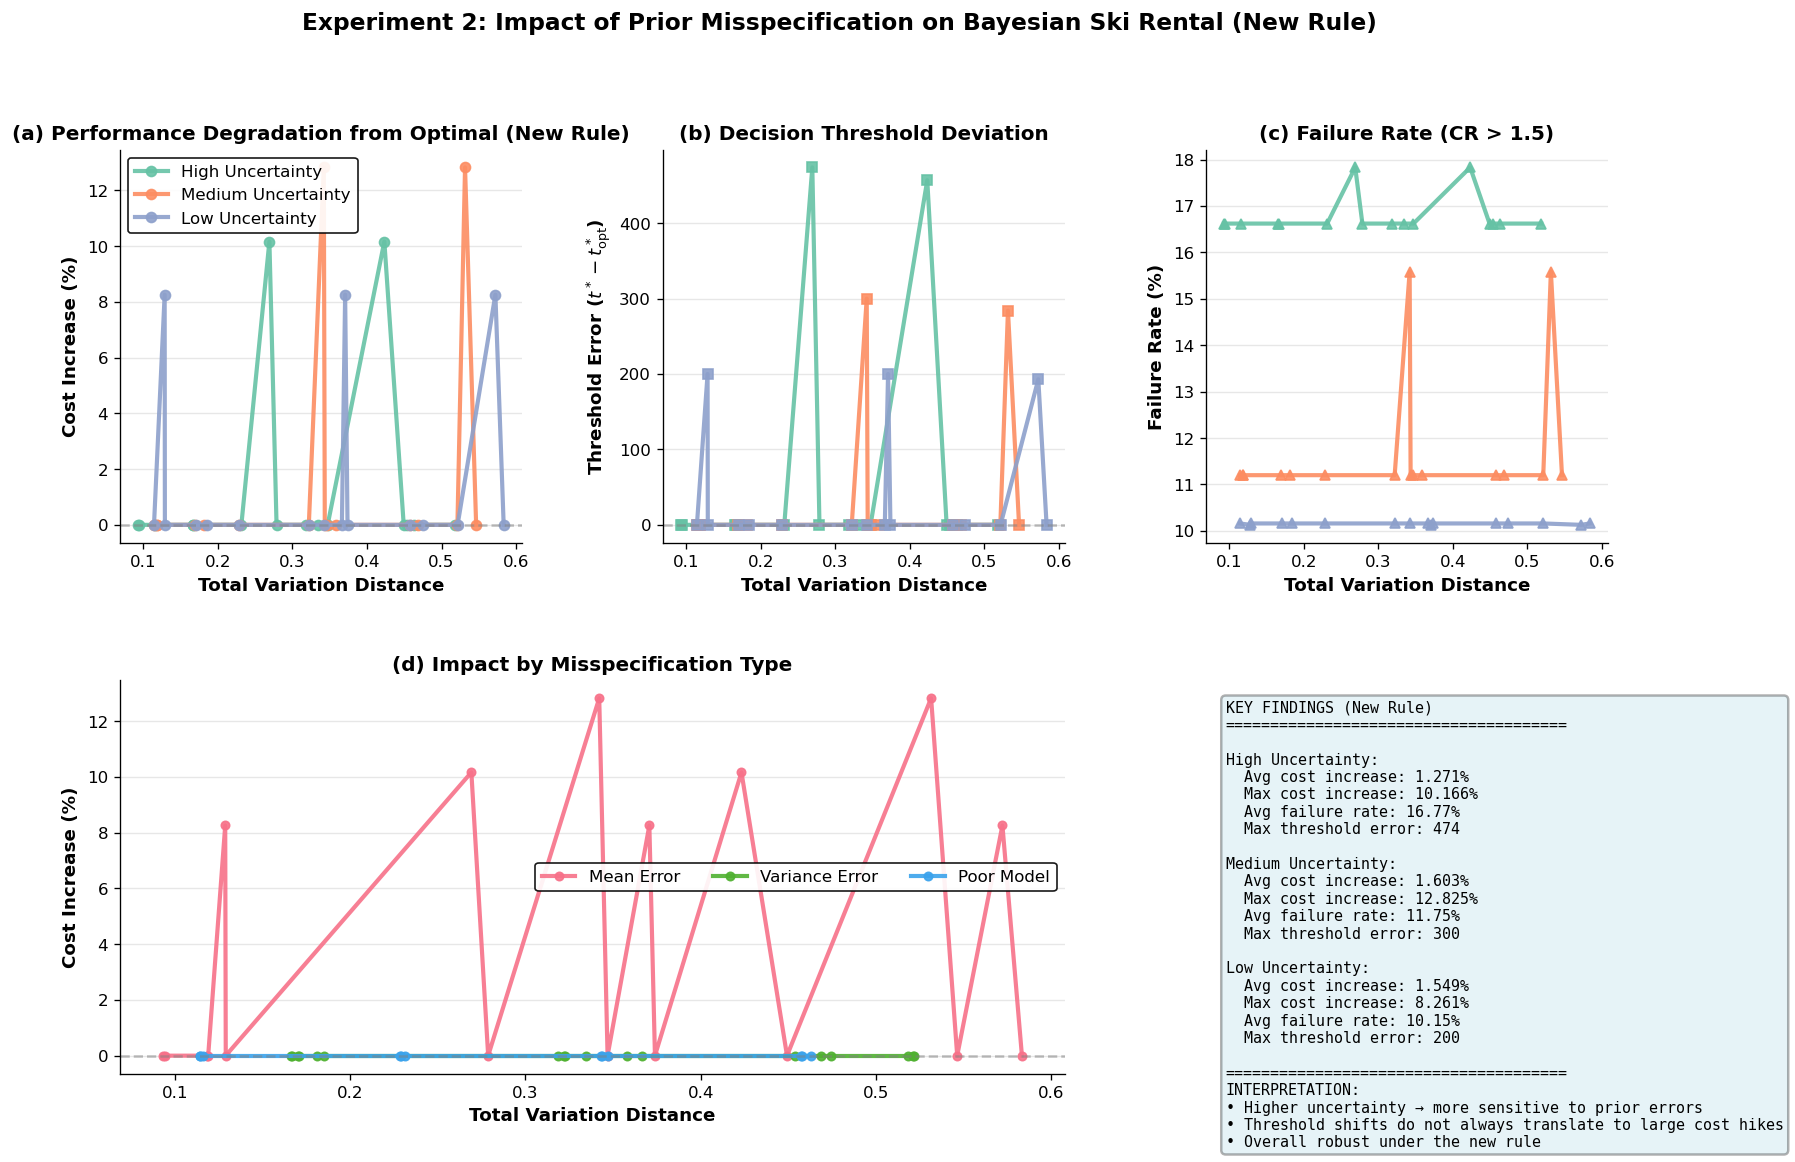

In [28]:
# =========================================================
# Experiment 3: Prior Misspecification Impact (FINAL, NEW RULE)
#  - Uses UPDATED buy rule: b <= E[T - t + 1 | T >= t]
#  - Research-ready plots/tables
#  - Multiple uncertainty regimes
# =========================================================
import os, numpy as np, pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

# --------------------------
# Global RNG for reproducibility
# --------------------------
rng = np.random.default_rng(20251110)

# --------------------------
# Priors
# --------------------------
def gaussian_prior(M: int, mean: float, std: float) -> np.ndarray:
    x = np.arange(1, M + 1, dtype=float)
    prior = stats.norm.pdf(x, mean, std)
    s = prior.sum()
    return prior / s if s > 0 else np.ones(M) / M

def uniform_prior(M: int) -> np.ndarray:
    return np.ones(M, dtype=float) / M

# --------------------------
# NEW threshold rule (cap removed)
# Buy at first t with  b <= E[T - t + 1 | T >= t]
# --------------------------
def compute_buy_threshold_tstar(b: int, prior: np.ndarray) -> int:
    """
    New Bayesian rule (no min{·, b} cap inside the expectation):
        E_rent(t) = E[T - t + 1 | T >= t] = E[T | T>=t] - (t-1)
        Buy at the first t such that b <= E_rent(t).
    Returns t*, or M+1 if never buy within horizon.
    """
    M = prior.size
    # Prefix sums (1-indexed indexing in formulas)
    P = np.concatenate([[0.0], np.cumsum(prior)])                      # P[k] = sum_{i<=k} prior_i
    W = np.concatenate([[0.0], np.cumsum(prior * np.arange(1, M + 1))])# W[k] = sum_{i<=k} i*prior_i

    for t in range(1, M + 1):
        S_t = P[M] - P[t - 1]             # tail mass = Pr[T >= t]
        if S_t <= 0:
            break
        ET_cond = (W[M] - W[t - 1]) / S_t # E[T | T >= t]
        E_rent = ET_cond - (t - 1)        # E[T - t + 1 | T >= t]
        if b <= E_rent:
            return t
    return M + 1

# --------------------------
# Metrics
# --------------------------
def compute_tv_distance(p1: np.ndarray, p2: np.ndarray) -> float:
    return 0.5 * np.abs(p1 - p2).sum()

# --------------------------
# Main experiment
# --------------------------
def comprehensive_misspecification_experiment():
    """
    Test robustness under three uncertainty regimes:
    - High: Large variance (σ/μ≈0.42)  → more sensitive to misspec.
    - Medium: Moderate variance (σ/μ≈0.33)
    - Low: Small variance (σ/μ≈0.31)   → more robust
    """
    n_trials = 10_000

    configs = [
        # (M, b, true_mean, true_std, label)
        (500, 110, 120, 50, 'High Uncertainty (σ/μ=0.42)'),
        (300,  80,  90, 30, 'Medium Uncertainty (σ/μ=0.33)'),
        (200,  60,  65, 20, 'Low Uncertainty (σ/μ=0.31)'),
    ]

    all_results = []

    print("\n" + "=" * 70)
    print("EXPERIMENT 3 (NEW RULE): PRIOR MISSPECIFICATION SENSITIVITY")
    print("=" * 70)

    for M, b, true_mean, true_std, config_label in configs:
        days = np.arange(1, M + 1)
        true_prior = gaussian_prior(M, true_mean, true_std)

        # Baseline: algorithm with the CORRECT prior (new rule)
        t_star_opt = compute_buy_threshold_tstar(b, true_prior)

        # Draw true horizons once per config for fair comparison across scenarios
        T_samples = rng.choice(days, size=n_trials, p=true_prior).astype(float)

        # Algorithm cost under baseline (new rule with correct prior)
        cost_opt_alg = np.where(T_samples < t_star_opt, T_samples, (t_star_opt - 1) + b)

        # Optimal offline cost for normalization (classical ski rental optimum)
        opt_cost = np.minimum(T_samples, b)

        cr_baseline = (cost_opt_alg / opt_cost).mean()
        baseline_cost = cost_opt_alg.mean()

        print(f"\n{config_label}")
        print(f"  Parameters: M={M}, b={b}, E[T]≈{true_mean}, σ≈{true_std}")
        print(f"  New-rule optimal threshold: t*={t_star_opt}")
        print(f"  Baseline CR: {cr_baseline:.4f}, Cost: {baseline_cost:.2f}")

        # Build misspecification scenarios
        scenarios = []

        # 1) Mean shift (under/over-estimation of horizon location)
        for shift in [-0.5, -0.3, -0.1, 0.1, 0.3, 0.5]:
            miss_mean = float(np.clip(true_mean * (1 + shift), 10, M - 10))
            scenarios.append(('Mean Error', shift,
                              gaussian_prior(M, miss_mean, true_std)))

        # 2) Variance mismatch (over/under-confidence)
        for var_f in [0.3, 0.5, 0.7, 1.5, 2.5, 4.0]:
            scenarios.append(('Variance Error', var_f,
                              gaussian_prior(M, true_mean, true_std * var_f)))

        # 3) Model quality (mixture with uniform)
        for delta in [0.2, 0.4, 0.6, 0.8]:
            mix = (1 - delta) * true_prior + delta * uniform_prior(M)
            mix /= mix.sum()
            scenarios.append(('Poor Model', delta, mix))

        # Evaluate each misspecified prior under the NEW rule
        for stype, param, miss_prior in scenarios:
            tv = compute_tv_distance(true_prior, miss_prior)
            t_star = compute_buy_threshold_tstar(b, miss_prior)

            cost = np.where(T_samples < t_star, T_samples, (t_star - 1) + b)
            cr = cost / opt_cost

            # Summary metrics
            avg_cost = cost.mean()
            regret_vs_baseline = avg_cost - baseline_cost
            pct_increase = (regret_vs_baseline / baseline_cost) * 100.0

            all_results.append({
                'config': config_label,
                'M': M, 'b': b,
                'scenario_type': stype,
                'parameter': float(param),
                'tv_distance': float(tv),
                'mean_cr': float(cr.mean()),
                'std_cr': float(cr.std(ddof=1)),
                'p95_cr': float(np.percentile(cr, 95)),
                'p99_cr': float(np.percentile(cr, 99)),
                'failure_rate': float(np.mean(cr > 1.5)),
                'severe_fail': float(np.mean(cr > 2.0)),
                't_star': int(t_star),
                't_star_optimal': int(t_star_opt),
                'threshold_error': int(t_star - t_star_opt),
                'avg_cost': float(avg_cost),
                'baseline_cost': float(baseline_cost),
                'regret': float(regret_vs_baseline),
                'pct_cost_increase': float(pct_increase),
            })

    return pd.DataFrame(all_results)

# --------------------------
# Polished plotting
# --------------------------
def plot_polished_results(df):
    import seaborn as sns

    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.35, wspace=0.35)

    configs = df['config'].unique()
    colors = sns.color_palette("Set2", len(configs))

    # (a) Performance degradation vs TV distance
    ax = fig.add_subplot(gs[0, 0])
    for i, cfg in enumerate(configs):
        data = df[df['config'] == cfg].sort_values('tv_distance')
        ax.plot(data['tv_distance'], data['pct_cost_increase'],
                'o-', linewidth=2.5, markersize=6, color=colors[i],
                label=cfg.split('(')[0].strip(), alpha=0.9)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
    ax.set_xlabel('Total Variation Distance', fontweight='bold')
    ax.set_ylabel('Cost Increase (%)', fontweight='bold')
    ax.set_title('(a) Performance Degradation from Optimal (New Rule)', fontsize=12, fontweight='bold')
    ax.legend(loc='best', frameon=True, edgecolor='black', framealpha=0.9)
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.3, linewidth=0.8)

    # (b) Threshold deviation
    ax = fig.add_subplot(gs[0, 1])
    for i, cfg in enumerate(configs):
        data = df[df['config'] == cfg].sort_values('tv_distance')
        ax.plot(data['tv_distance'], data['threshold_error'],
                's-', linewidth=2.5, markersize=6, color=colors[i], alpha=0.9)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
    ax.set_xlabel('Total Variation Distance', fontweight='bold')
    ax.set_ylabel(r'Threshold Error ($t^* - t^*_{\mathrm{opt}}$)', fontweight='bold')
    ax.set_title('(b) Decision Threshold Deviation', fontsize=12, fontweight='bold')
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.3, linewidth=0.8)

    # (c) Failure rate
    ax = fig.add_subplot(gs[0, 2])
    for i, cfg in enumerate(configs):
        data = df[df['config'] == cfg].sort_values('tv_distance')
        ax.plot(data['tv_distance'], data['failure_rate'] * 100.0,
                '^-', linewidth=2.5, markersize=6, color=colors[i], alpha=0.9)
    ax.set_xlabel('Total Variation Distance', fontweight='bold')
    ax.set_ylabel('Failure Rate (%)', fontweight='bold')
    ax.set_title('(c) Failure Rate (CR > 1.5)', fontsize=12, fontweight='bold')
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.3, linewidth=0.8)

    # (d) By scenario type
    ax = fig.add_subplot(gs[1, :2])
    types = ['Mean Error', 'Variance Error', 'Poor Model']
    type_colors = sns.color_palette("husl", len(types))
    for i, stype in enumerate(types):
        data = df[df['scenario_type'] == stype].sort_values('tv_distance')
        ax.plot(data['tv_distance'], data['pct_cost_increase'],
                'o-', linewidth=2.5, markersize=5, color=type_colors[i],
                label=stype, alpha=0.9)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
    ax.set_xlabel('Total Variation Distance', fontweight='bold')
    ax.set_ylabel('Cost Increase (%)', fontweight='bold')
    ax.set_title('(d) Impact by Misspecification Type', fontsize=12, fontweight='bold')
    ax.legend(loc='best', ncol=3, frameon=True, edgecolor='black', framealpha=0.9)
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.3, linewidth=0.8)

    # (e) Summary table
    ax = fig.add_subplot(gs[1, 2])
    ax.axis('off')

    summary_lines = ["KEY FINDINGS (New Rule)", "=" * 38, ""]
    for cfg in configs:
        cfg_data = df[df['config'] == cfg]
        cfg_name = cfg.split('(')[0].strip()
        summary_lines.append(f"{cfg_name}:")
        summary_lines.append(f"  Avg cost increase: {cfg_data['pct_cost_increase'].mean():.3f}%")
        summary_lines.append(f"  Max cost increase: {cfg_data['pct_cost_increase'].max():.3f}%")
        summary_lines.append(f"  Avg failure rate: {cfg_data['failure_rate'].mean()*100:.2f}%")
        summary_lines.append(f"  Max threshold error: {abs(cfg_data['threshold_error']).max():.0f}")
        summary_lines.append("")

    summary_lines.append("=" * 38)
    summary_lines.append("INTERPRETATION:")
    summary_lines.append("• Higher uncertainty → more sensitive to prior errors")
    summary_lines.append("• Threshold shifts do not always translate to large cost hikes")
    summary_lines.append("• Overall robust under the new rule")

    summary_text = "\n".join(summary_lines)
    ax.text(0.05, 0.95, summary_text,
            transform=ax.transAxes, fontsize=9, family='monospace',
            va='top',
            bbox=dict(boxstyle='round', facecolor='lightblue',
                      alpha=0.3, edgecolor='black', linewidth=1.5))

    plt.suptitle('Experiment 2: Impact of Prior Misspecification on Bayesian Ski Rental (New Rule)',
                 fontsize=14, fontweight='bold', y=0.995)
    return fig

# --------------------------
# Execution
# --------------------------
mpl.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "legend.fontsize": 10,
    "figure.dpi": 120,
    "savefig.dpi": 600,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

df = comprehensive_misspecification_experiment()

os.makedirs("figs-bosun", exist_ok=True)

fig = plot_polished_results(df)
fig.savefig("figs-bosun/exp3_prior_misspecification_FINAL.png", bbox_inches="tight")
df.to_csv("figs-bosun/exp3_prior_misspecification_FINAL.csv", index=False)

# --------------------------
# Detailed analysis / console report
# --------------------------
print("\n" + "="*70)
print("DETAILED ANALYSIS (New Rule)")
print("="*70)

for cfg in df['config'].unique():
    cfg_data = df[df['config'] == cfg]
    print(f"\n{cfg}:")
    print(f"  Mean cost increase: {cfg_data['pct_cost_increase'].mean():.4f}%")
    print(f"  Std of cost increase: {cfg_data['pct_cost_increase'].std():.4f}%")
    print(f"  Max cost increase: {cfg_data['pct_cost_increase'].max():.4f}%")
    print(f"  Mean failure rate: {cfg_data['failure_rate'].mean()*100:.3f}%")
    print(f"  Max threshold error: {abs(cfg_data['threshold_error']).max():.0f}")

    # Worst scenarios
    worst_3 = cfg_data.nlargest(3, 'pct_cost_increase')
    print(f"  Top 3 worst scenarios:")
    for idx, (_, row) in enumerate(worst_3.iterrows(), 1):
        print(f"    {idx}. {row['scenario_type']} (param={row['parameter']:.2f}): "
              f"+{row['pct_cost_increase']:.3f}%, threshold error={row['threshold_error']:.0f}")

# # --------------------------
# # LaTeX table summary
# # --------------------------
# print("\n" + "="*70)
# print("LATEX TABLE (copy to paper)")
# print("="*70)

# latex_summary = df.groupby('config').agg({
#     'pct_cost_increase': ['mean', 'max'],
#     'threshold_error': lambda x: f"[{x.min():.0f}, {x.max():.0f}]",
#     'failure_rate': ['mean', 'max'],
# }).round(4)

# print(latex_summary.to_latex())

print(f"\n{'='*70}")
print(f"✓ Complete! Saved to: figs-bosun/exp3_prior_misspecification_FINAL.*")
print(f"{'='*70}\n")
